## TODO:

- input z nazwą foldera ze zdjęciami (DONE)
- zamiast det_num, alfa i last_first, oficjalne nazwy zmiennych (DONE)
- akceptowanie wczytywania zdjęcia (*)
- zamienić polskie nazwy na angielskie (DONE)
- przy wybieraniu det_num, alfa i last_first wczytywać także do zmiennych -> https://github.com/jupyter-widgets/ipywidgets/issues/1947
- napisać funkcję do rysowania sinogramu która przyjmuje y jako parametr (DONE)
- napisać analogiczną funkę do sinogramtoResultImage (DONE)


In [1]:
from bresenham import bresenham
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipykernel.pylab.backend_inline import flush_figures
from skimage import io

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import os
from IPython.display import Image
import math

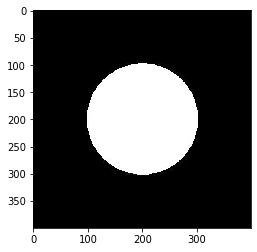

(400, 400)

In [56]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def readImage(filepath):
    return rgb2gray(mpimg.imread(filepath))

def showImage(img):
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.show()

image = readImage('tomograf-zdjecia/Kolo.jpg')
#image = shepp_logan_phantom()
#image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
showImage(image)
image_x, image_y = image.shape[0], image.shape[1]
image.shape

In [39]:
sinogram = None

angleSpace = np.pi / 160 
angleRange = np.pi 
numberOfDetectors = 180

In [40]:
def circleCentre(image):
    coords = list(map(lambda x: x / 2, image.shape))
    radius = (coords[0] ** 2 + coords[1] ** 2) ** 0.5
    return {'x': coords[0], 'y': coords[1], 'r': radius}

circleCoords = circleCentre(image)
circleCoords

{'x': 200.0, 'y': 200.0, 'r': 282.842712474619}

In [41]:
directoryName = input("Enter name of directory with images: ")
directoryName = directoryName + "/"

radius = circleCoords['r'] 

@interact (numberOfDetectors=widgets.IntSlider(min=90, max=720, step=90), angleSpace=widgets.IntSlider(min=10, max=180, step=10), angleRange=widgets.IntSlider(min=45, max=270, step=45))
#TODO: zmienić z wyswietlania na podstawianie odpowiednich zmiennych

def input_data(numberOfDetectors, angleSpace, angleRange):    #użytkownik podaje l. detektorow, przesuniecie alfa i rozwartosc detektorow
    
    print('number of detectors: ', numberOfDetectors, '\nspace between adjecent detectors: ', angleSpace, '\ndistance between first and last detector: ', angleRange)

#w = interactive(sinogramToResultImage, withAnimation=False, angleSpace=fixed(angleSpace), angleRange=fixed(angleRange));

@interact
def show_images(file=os.listdir(directoryName)):
    display(Image(directoryName + file))

#wyswietlenie opcji animacji
#trzeba trochę poczekać, aż funkcja się cała wykona, ale ogólnie ładnie działa
# display(w)
#num_det

Enter name of directory with images: tomograf-zdjecia


interactive(children=(IntSlider(value=90, description='numberOfDetectors', max=720, min=90, step=90), IntSlide…

interactive(children=(Dropdown(description='file', options=('Shepp_logan.jpg', 'CT_ScoutView.jpg', 'CT_ScoutVi…

In [57]:
def getPosition(alpha):
    x = circleCoords['x'] + circleCoords['r'] * np.cos(alpha)
    y = circleCoords['y'] + circleCoords['r'] * np.sin(alpha)
    return [int(x), int(y)]

def readValue(emi_x, emi_y, det_x, det_y):
    allPoints = list(bresenham(emi_x, emi_y, det_x, det_y))
    brightnessSum = 0
    pixelsNum = 0
    for point in allPoints:
        point_x = point[0]
        point_y = point[1]
        if (point_x > 0 and point_x < image_x and point_y > 0 and point_y < image_y):
            pixelsNum += 1
            brightnessSum += image[point_x][point_y]
    if pixelsNum > 0:
        val = brightnessSum / pixelsNum
        return val
    else:
        return 0

fullExtent = 2 * np.pi
numberOfEmitterPositions = int(fullExtent/ angleSpace)
                            
positionForSin = np.zeros((numberOfEmitterPositions, numberOfDetectors, 2, 2))

@interact (angleSpace=fixed(angleSpace), angleRange=fixed(angleRange), numberOfDetectors=widgets.IntSlider(min=90, max=720, step=90))
def toSinogram(angleSpace, angleRange, numberOfDetectors):
    
    sin = np.zeros((numberOfEmitterPositions, numberOfDetectors))
    
    for emitterAngle, i in zip(np.arange(0, fullExtent, angleSpace), range(numberOfEmitterPositions)):
        emitterPosition = getPosition(emitterAngle)
        
        emitterAtLeft = emitterAngle + np.pi - angleRange / 2
        emitterAtRight = emitterAngle + np.pi + angleRange / 2
        angleForDetector = angleRange / numberOfDetectors
        
        for detectorAngle, j in zip(np.arange(emitterAtLeft, emitterAtRight, angleForDetector), range(numberOfDetectors)):
            detectorPosition = getPosition(detectorAngle)
            sin[i][j] = readValue(emitterPosition[0], emitterPosition[1], detectorPosition[0], detectorPosition[1])
            positionForSin[i][j] = [detectorPosition, emitterPosition]
                               
    return sin, positionForSin


            
sinogram, positionForSin = toSinogram(angleSpace, angleRange, numberOfDetectors)

interactive(children=(IntSlider(value=90, description='numberOfDetectors', max=720, min=90, step=90), Output()…

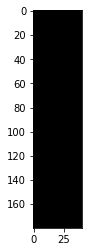

In [43]:
def imageAnimation(y):
    max_y = sinogram.shape[0]
    if y < max_y:
        tempSinogram = np.zeros((sinogram.shape[1],y))
        for y in range(y):
            for x in range(sinogram.shape[1]):
                tempSinogram[x][y] = int(255*sinogram[x][y])
    else:
        pass
    showImage(tempSinogram)
    
imageAnimation(40)

In [44]:
y = widgets.IntSlider(min=0, max=numberOfDetectors, description='y')

out = widgets.interactive_output(imageAnimation, {'y': y})

widgets.HBox([widgets.VBox([y]), out])

In [45]:
positionForSin[0][0]
#positionForSin[1][0]

array([[200., 482.],
       [482., 200.]])

In [46]:
np.amax(sinogram)

130.3528781954882

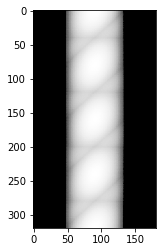

In [47]:
"""def makeSinogram3D(sinogram):
    sinogram_3d = np.zeros((sinogram.shape[0], sinogram.shape[1], 3))
    for i in range(sinogram.shape[0]):
        for j in range(sinogram.shape[1]):
            val = sinogram[i][j]
            sinogram_3d[i][j] = [val, val, val]
            
    return sinogram_3d
"""
#sinogram_3d = makeSinogram3D(sinogram)
showImage(sinogram)

In [48]:
resultImage = np.zeros(image.shape)
countForPoints = np.zeros(image.shape)
resultStepByStep = [np.zeros(image.shape)]
countForPointsStepByStep = [np.zeros(image.shape)]

def normalizeStep(step):
    for x in range(len(countForPointsStepByStep[step])):
        for y in range(len(countForPointsStepByStep[step][x])):
            val = countForPointsStepByStep[step][x][y]
            if val[0] != 0:
                resultStepByStep[step][x][y] /= val
                
    return resultStepByStep

In [58]:
def addLineToResult(emi_x, emi_y, det_x, det_y, value):
    
    allPoints = list(bresenham(int(emi_x), int(emi_y), int(det_x), int(det_y)))
    for point in allPoints:
        point_x = point[0]
        point_y = point[1]
        if 0 <= point_x and image_x > point_x and 0 <= point_y and image_y > point_y:
            countForPoints[point_x][point_y] += 1
            resultImage[point_x][point_y] += value
      
    return countForPoints, resultImage

In [ ]:
def sinogramToResultImage(angleSpace, angleRange):   
    for i in range(sinogram.shape[0]):
        for j in range(sinogram.shape[1]):
            emitterPosition = positionForSin[i][j][1]
            detectorPosition = positionForSin[i][j][0]
            countForPoints, resultImage = addLineToResult(emitterPosition[0], emitterPosition[1], detectorPosition[0], detectorPosition[1], sinogram[i][j]) 
            
                      
sinogramToResultImage(angleSpace, angleRange)
showImage(resultImage)

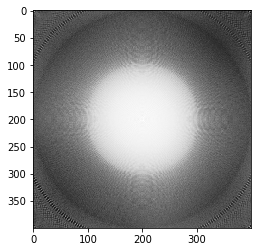

In [53]:
def divideByCountForPoints(resultImage):
    for i in range(resultImage.shape[0]):
        for j in range(resultImage.shape[1]):
            if countForPoints[i][j] != 0:
                resultImage[i][j] /= countForPoints[i][j]
            else:
                resultImage[i][j] = 0
                
    return resultImage
                
resultImage = divideByCountForPoints(resultImage)
showImage(resultImage)

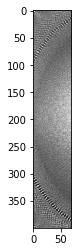

In [54]:
#imageAnimation(resultImage, 70)
def resultImageAnimation(z):
    max_y = resultImage.shape[0]
    if z < max_y:
        tempSinogram = np.zeros((resultImage.shape[1],z))
        for y in range(z):
            for x in range(resultImage.shape[1]):
                tempSinogram[x][y] = int(255*resultImage[x][y])
    else:
        pass
    showImage(tempSinogram)
    
resultImageAnimation(70)

In [55]:
z = widgets.IntSlider(min=0, max=resultImage.shape[0] - 1, description='z')

out = widgets.interactive_output(resultImageAnimation, {'z': z})

widgets.HBox([widgets.VBox([z]), out])

# Dla sprawdzenia - przy użyciu gotowych funkcji

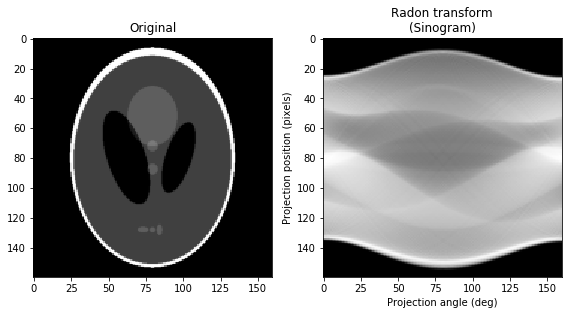

In [105]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
#image = readImage('tomograf-zdjecia/Kolo.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
"""ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')"""
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()